In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
from astropy.time import Time
from astropy.coordinates import Distance
from astropy import units as u
import numpy as np

In [2]:
base_dir = Path().absolute()
data_dir = os.path.join(base_dir, "data")

In [3]:
t_peak_mjd = Time(58603.87, format="mjd")
t_neutrino = Time("2019-10-01T20:09:18.17", format='isot', scale='utc')

bran_z = 0.0512

xpath = os.path.join(data_dir, "BranStark.dat")
# with open(xpath, "r") as f:
#     print(f.read())

In [4]:
df = pd.read_table(xpath, skiprows=4, sep="\s+")
print(df)

     #day_since_peak   band   flux_Jy       nu_rest           lum  \
0           15.54514   UVW2  0.000517  1.569084e+15  9.392264e+43   
1           19.23147   UVW2  0.000463  1.569084e+15  8.409503e+43   
2           22.20333   UVW2  0.000422  1.569084e+15  7.669557e+43   
3           25.16893   UVW2  0.000411  1.569084e+15  7.460541e+43   
4           28.24098   UVW2  0.000411  1.569084e+15  7.460541e+43   
..               ...    ...       ...           ...           ...   
191         34.81478  r.ZTF  0.000159  4.961606e+14  5.833004e+42   
192         38.61815  r.ZTF  0.000151  4.961606e+14  5.556640e+42   
193         44.28862  r.ZTF  0.000145  4.961606e+14  5.302641e+42   
194         47.13955  r.ZTF  0.000138  4.961606e+14  5.057923e+42   
195         56.65696  r.ZTF  0.000125  4.961606e+14  4.573959e+42   

          err_lum        lum_kc        lum_bb  
0    2.595179e+42  1.217448e+43  2.614296e+44  
1    4.647263e+42  1.105933e+43  2.270555e+44  
2    3.531962e+42  1.022367

In [5]:
meerkat_path = os.path.join(data_dir, "at2019dsg_MeerKAT.txt")
meerkat_data = pd.read_table(meerkat_path, sep="\s+")
print(meerkat_data)

       #mjd           date  flux_mJy  flux_err_mJy
0  58653.08  2019-Jun-19.1     0.104          0.18
1  58694.00  2019-Jul-30.0     0.111          0.17
2  58761.79  2019-Oct-05.8     0.152          0.19


In [6]:
radio_data = [x for x in os.listdir(data_dir) if "at2019dsg_20" in x]
print(radio_data)
vla_data = []
for x in radio_data:
    with open(os.path.join(data_dir, x), "r") as f:
        print(x)
        rawdate = (x.split("_")[1][:8])
        obs_date = Time("{0}-{1}-{2}T00:00:00.00".format(rawdate[:4], rawdate[4:6], rawdate[6:]), format='isot', scale='utc')
        for line in f.readlines():
            line = line.replace("\n", "")
            vla_data.append(tuple([obs_date.mjd] +  [float(x) for x in line.split(" ")]))
            
vla_data = pd.DataFrame(vla_data, columns=["mjd", "frequency", "flux", "flux_err"])
print(vla_data)
#             vla_data.append()
#         print(f.read())

['at2019dsg_20190808.txt', 'at2019dsg_20190522.txt', 'at2019dsg_20191005.txt', 'at2019dsg_20190619.txt']
at2019dsg_20190808.txt
at2019dsg_20190522.txt
at2019dsg_20191005.txt
at2019dsg_20190619.txt
        mjd  frequency   flux  flux_err
0   58703.0   2.243000  0.249     0.064
1   58703.0   2.755001  0.345     0.050
2   58703.0   3.179001  0.255     0.047
3   58703.0   3.691001  0.419     0.037
4   58703.0   4.737001  0.698     0.030
5   58703.0   5.761001  0.829     0.033
6   58703.0   6.687001  0.987     0.030
7   58703.0   7.711001  1.117     0.030
8   58703.0   8.487001  1.194     0.031
9   58703.0   9.511001  1.238     0.030
10  58703.0  10.137000  1.310     0.032
11  58703.0  11.161000  1.356     0.032
12  58625.0   8.487001  0.290     0.028
13  58625.0   9.511001  0.408     0.029
14  58625.0  10.487000  0.440     0.028
15  58625.0  11.511000  0.412     0.031
16  58761.0   2.243000  0.351     0.052
17  58761.0   2.755000  0.744     0.039
18  58761.0   3.243001  0.920     0.034
19 

In [7]:
# Formula from https://arxiv.org/abs/1510.01226

print(Distance(z=bran_z))

peak_f = []
peak_flux = []
dates = []
for date in sorted(list(set(vla_data["mjd"]))):
    data = vla_data[vla_data["mjd"] == date]
    max_index = list(data["flux"]).index(max(data["flux"]))
    peak_f.append(list(data["frequency"])[max_index])
    peak_flux.append(max(data["flux"]))
    dates.append(date)
dates = np.array(dates)
    
peak_f = np.array(peak_f)
peak_flux = np.array(peak_flux)

# f_a = 1.0 for spherical or 0.1 for conical
f_v = 4./3.
    
def equipartition_energy(peak_f, peak_flux, f_a=1.0):
    return (1.9 * 10**46) * u.erg * (
        (peak_flux ** (23./19.)) * 
        ((Distance(z=bran_z).to(u.cm)/(u.cm * 10**26))**(46./19.)) *
        ((peak_f/10.) ** -1.) * 
        ((1 + bran_z) ** (-42./19.)) * 
        (f_a ** (-12./19.)) * 
        (f_v ** (8./19.))
    )

def equipartition_radius(peak_f, peak_flux, f_a=1.0):
    return (3.2 * 10**15) * u.cm * (
        (peak_flux ** (9./19.)) * 
        ((Distance(z=bran_z).to(u.cm)/(u.cm * 10**26))**(18./19.)) *
        ((peak_f/10.) ** -1.) * 
        ((1 + bran_z) ** (-10./19.)) * 
        (f_a ** (-8./19.)) * 
        (f_v ** (1./19.))
    )


print(peak_f)
print(peak_flux)
print(equipartition_energy(peak_f, peak_flux))

235.34004597982002 Mpc
[10.487    11.511    11.161     5.761001]
[0.44  0.771 1.356 1.379]
[8.23760113e+47 1.47987572e+48 3.02317071e+48 5.97737099e+48] erg


In [8]:
bands = list(set(df["band"]))
print(bands)

['UVW1', 'UVM2', 'g.ZTF', 'B', 'r.SEDM', 'U', 'r.IOO', 'g.IOO', 'UVW2', 'r.ZTF']


        mjd  frequency   flux  flux_err
30  58653.0   5.511001  0.324     0.029
5   58703.0   5.761001  0.829     0.033
21  58761.0   5.761001  1.379     0.030
        mjd  frequency   flux  flux_err
14  58625.0     10.487  0.440     0.028
35  58653.0     10.487  0.756     0.030
10  58703.0     10.137  1.310     0.032
26  58761.0     10.137  0.884     0.029


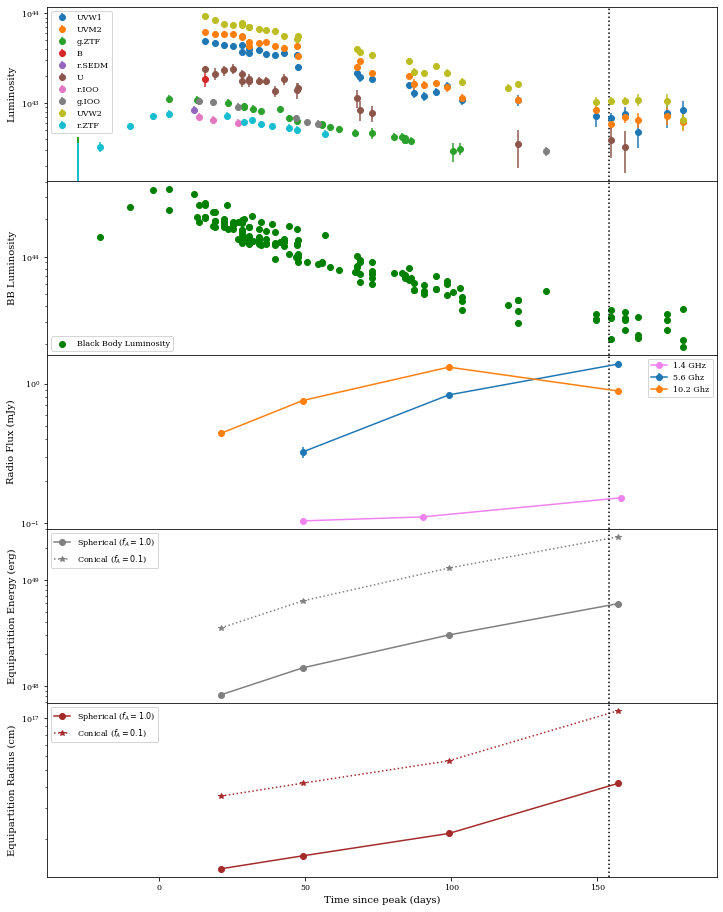

In [13]:
plt.figure(figsize=(12, 16))

ax1 = plt.subplot(511)

# Plot luminosity

for band in bands:
    data = df[df["band"] == band]
    ax1.errorbar(data["#day_since_peak"], data["lum"], yerr=data["err_lum"],  fmt='o', label=band)
    
ax1.set_ylabel("Luminosity")
ax1.legend()
ax1.set_yscale("log")
ax1.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":", label="IC191001A")

# Plot Black Body Luminosity

ax2 = plt.subplot(512, sharex=ax1)
ax2.scatter(df["#day_since_peak"][df["lum_bb"] > 0], df["lum_bb"][df["lum_bb"] > 0], color="green", label="Black Body Luminosity")

ax2.set_yscale("log")
ax2.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax2.set_ylabel("BB Luminosity")
ax2.legend()


# Plot Radio

ax3 = plt.subplot(513, sharex=ax1)
ax3.plot(meerkat_data["#mjd"] - t_peak_mjd.mjd, meerkat_data["flux_mJy"], marker="o", color="violet", label="1.4 GHz")
ax3.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")

for frequency in [5.6, 10.2]:
    data = vla_data[abs(vla_data["frequency"] - frequency) < 0.5]
    data = data.sort_values("mjd")
    print(data)
    ax3.errorbar(data["mjd"]- t_peak_mjd.mjd, data["flux"],  yerr=data["flux_err"], marker="o", label="{0} Ghz".format(frequency))

ax3.legend()
ax3.set_ylabel("Radio Flux (mJy)")
ax3.set_yscale("log")

ax4 = plt.subplot(514, sharex=ax1)

ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux),  marker="o", color="gray", label=r"Spherical ($f_{A}=1.0$)")
ax4.plot(dates - t_peak_mjd.mjd, equipartition_energy(peak_f, peak_flux, f_a=0.1),  marker="*", linestyle=":", color="gray", label=r"Conical ($f_{A}=0.1$)")
ax4.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax4.set_yscale("log")
ax4.set_ylabel("Equipartition Energy (erg)",)
ax4.legend()
ax5 = plt.subplot(515, sharex=ax1)
ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux), marker="o", color="brown", label=r"Spherical ($f_{A}=1.0$)")
ax5.plot(dates - t_peak_mjd.mjd, equipartition_radius(peak_f, peak_flux, f_a=0.1),  marker="*", linestyle=":", color="brown", label=r"Conical ($f_{A}=0.1$)")

ax5.axvline(t_neutrino.mjd - t_peak_mjd.mjd, color="k", linestyle=":")
ax5.set_yscale("log")
ax5.set_ylabel("Equipartition Radius (cm)")
ax5.legend()

plt.xlabel("Time since peak (days)")
plt.subplots_adjust(hspace=.0)